In [1]:
#import modules
import os
import pickle
import numpy as np 
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
BASE_DIR = 'D:\Image caption generator\Flicker8k'
WORKING_DIR ='D:\Image caption generator\working'

In [4]:
#extract image features

#load vgg16 model 
modelv=VGG16()
#restructure the model 
modelv= Model(inputs=modelv.inputs,outputs=modelv.layers[-2].output) #we dont need the fully connected layer of vgg16 
#summarize
print(modelv.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
#extract features from image
features = {}
directory = os.path.join(BASE_DIR,'Images')

for img_name in tqdm(os.listdir(directory)):
    #load image from file
    img_path = directory+ '/' +img_name
    image = load_img(img_path,target_size=(224,224))
    
    #convert img pixels to np array 
    image=img_to_array(image)
    
    #reshape data for model 
    image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    
    #preprocess image for vgg 
    image=preprocess_input(image)
    
    #extract features
    feature = model.predict(image,verbose=0)
    
    #get image ID
    image_id=img_name.split('.')[0]
    
    #store features
    features[image_id]=feature
    

In [6]:
# #store features in pickle 
# pickle.dump(features, open(os.path.join(WORKING_DIR,'features.pkl') , 'wb'))

In [5]:
#load features from pickle 
with open(os.path.join(WORKING_DIR,'features.pkl'),'rb') as f :
    features= pickle.load(f)

In [6]:
#load the captions 

with open(os.path.join(BASE_DIR,'captions.txt'),'r') as f:
    
    next(f) #to skip first line in the txt file 
    captions_doc=f.read()

In [7]:
captions_doc

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .\n1002674143_1b742ab4b8.j

In [8]:
#create mapping of image to captions 
mapping={}
#process lines 
for line in tqdm(captions_doc.split('\n')):
    #split the line by comma(,)
    tokens =line.split(',')
    if len(line)<2: #to handle wrong captions like one letter or one word 
        continue
    image_id,caption = tokens[0],tokens[1:]
    #remove extension from image
    image_id= image_id.split('.')[0]
    #convert caption list into string 
    caption = "  ".join(caption)
    #create list if needed 
    if image_id not in mapping :
        mapping[image_id]=[]
    #store the caption     
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(mapping)

8091

In [10]:
mapping

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'There is a gi

In [11]:
def clean(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
            #take one caption at time 
            caption=captions[i]
            
            #PREPROCESSING

            #convert to lowercase 
            caption=caption.lower()
            #delete digits , special chars , etc..
            caption=caption.replace('[^A-za-z]','')
            #delete additional spaces 
            caption=caption.replace('\s+',' ')
            #add start and end tags to the captions (for seq2seq model)
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i]=caption

In [12]:
#before preprocessing 
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [13]:
#preprocess the text 
clean(mapping)

In [14]:
#after preprocessing 
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [15]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [16]:
len(all_captions)

40455

In [17]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [18]:
# tokenize the text 
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1 #extra 1 accounts for the padding index 0

In [19]:
vocab_size

8485

In [20]:
#get maximum length of the caption available 
max_length = max(len(caption.split())for caption in all_captions)
max_length

35

In [21]:
#train test split 
image_ids = list(mapping.keys())
split = int(len(image_ids)*0.90) #90% as training data 
train =image_ids[:split]
test =image_ids[split:]

In [22]:
#create data generator to get data in batch to avoid sessin crashing 
def data_generator(data_keys,mapping,features,tokenizer,max_length,vocab_size,batch_size):
    #loop over images 
    X1,X2,y=list(),list(),list()
    n=0
    while 1:
        for key in data_keys:
            n+=1
            captions =mapping[key]
            #preprocess each caption 
            for caption in captions:
                #encode the sequence 
                seq = tokenizer.texts_to_sequences([caption])[0]
                #split the seq into X,Y pairs
                for i in range(1,len(seq)):
                    #split into input and output pairs 
                    in_seq,out_seq = seq[:i],seq[i]
                    #pad input sequence
                    in_seq = pad_sequences([in_seq],maxlen=max_length)[0]
                    #encode output sequence 
                    out_seq= to_categorical([out_seq],num_classes=vocab_size)[0]

                    #store the sequences 
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1,X2,y = np.array(X1),np.array(X2),np.array(y)
                yield [X1,X2] , y
                X1 , X2 , y = list(),list(),list()
                n=0
                       
                

    
    

In [23]:
#<start> girl going into wooden building <end>
#          x                                  y
#<start>                                 |   girl
#<start> girl                            |   going
#<start> girl going                      |   into
#<start> girl going into                 |   wooden
#..............
#<start> girl going into wooden building |   <end>

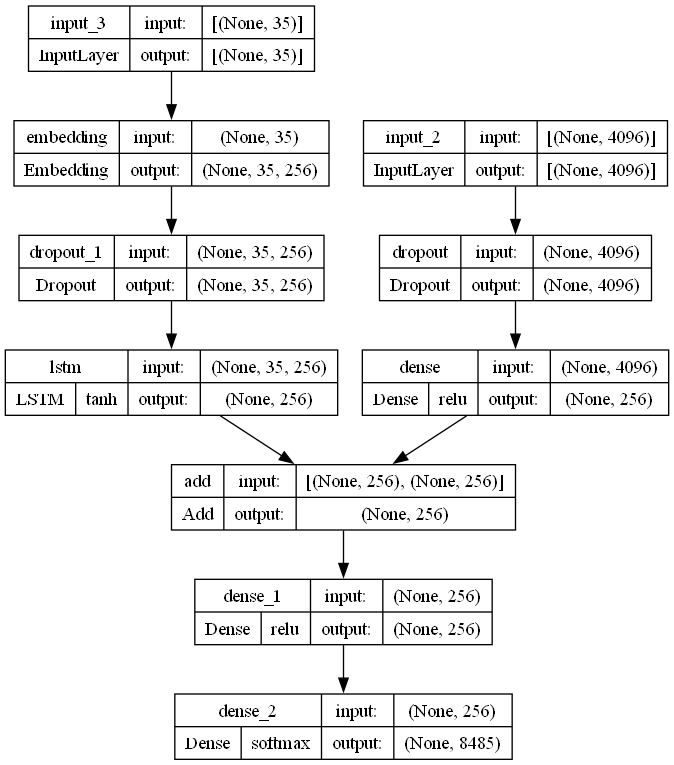

In [24]:
#model creation

#Encoder

#image feature model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256,activation='relu')(fe1)
#sequence feature model 
inputs2= Input(shape=(max_length,))
se1 = Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

#Decoder 
decoder1 = add([fe2,se3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

model = Model(inputs = [inputs1,inputs2] , outputs = outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam')


#plot the model
plot_model(model,show_shapes=True,show_layer_names=True,show_layer_activations=True,to_file='model.png')



In [27]:
#train the model 
epochs=20
batch_size=32
steps=len(train) // batch_size

for i in range(epochs):
    #create data generator
    generator = data_generator(train,mapping,features,tokenizer,max_length,vocab_size,batch_size)
    #fit for one epoch 
    model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)

227/227 [==============================] - 35s 154ms/step - loss: 2.1869


In [28]:
model.save('ImgCG.h5') 

In [25]:
from keras.models import load_model

# Load the model from file
model = load_model('ImgCG.h5')

In [26]:
#generate captions for image 

def idx_to_word(integer,tokenizer):
    for word,index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None       

In [27]:
#generate caption for an image 
def predict_caption(model,image,tokenizer,max_length):
    # add start tag for generation process
    in_text='startseq'
    # iterate over max length of sequence
    for i in range(max_length):
        #encode input sequence
        sequence=tokenizer.texts_to_sequences([in_text])[0]
        #pad sequence 
        sequence = pad_sequences([sequence],max_length)
        #predict next word 
        y_hat=model.predict([image,sequence],verbose=0)
        #get index of high probability
        y_hat=np.argmax(y_hat)
        # convert index to word
        word = idx_to_word(y_hat,tokenizer)
        #stop if word not found 
        if word is None:
            break
        #append word as input for generating next word 
        in_text+=" "+word 
        #stop if we reach end tag 
        if word =="endseq":
            break
    return in_text     
    

In [32]:
from nltk.translate.bleu_score import corpus_bleu
#validate with test data
actual , predicted = list(),list()

for key in tqdm(test):
    #get actual caption
    captions=mapping[key]
    #predict the caption for image 
    y_pred = predict_caption(model,features[key],tokenizer,max_length)
    #split into words 
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    #append to the list 
    actual.append(actual_captions)
    predicted.append(y_pred)
    
#calculate BLEU score 
print("BLEU-1: %f" % corpus_bleu(actual,predicted,weights=(1,0,0,0,0)))
print("BLEU-2: %f" % corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0,0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.538365
BLEU-2: 0.312275


In [28]:
#Visualize the Results 
from PIL import Image 
import matplotlib.pyplot as plt 
def generate_captions(image_name):
    #load the image 
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id=image_name.split('.')[0]
    img_path=os.path.join(BASE_DIR,"Images",image_name)
    image = Image.open(img_path)
    captions=mapping[image_id]
    print('<<<<<<<<<<<<<<<<<<<<ACTUAL>>>>>>>>>>>>>>>>>>>>>>')
    for caption in captions :
        print(caption)
    #predict caption 
    y_pred = predict_caption(model,features[image_id],tokenizer,max_length)
    print('<<<<<<<<<<<<<<<<<<<PREDICTED>>>>>>>>>>>>>>>>>>>>')
    print((f"Caption: {y_pred[8:-7]}"))
    plt.imshow(image)


<<<<<<<<<<<<<<<<<<<<ACTUAL>>>>>>>>>>>>>>>>>>>>>>
startseq the two greyhound dogs wearing sweaters are playing in the grass endseq
startseq two dogs play in the grass endseq
startseq two dogs wearing shirts play in the green grass endseq
startseq two dogs wearing sweaters play in field endseq
startseq two dogs wearing sweaters play in the grass endseq
<<<<<<<<<<<<<<<<<<<PREDICTED>>>>>>>>>>>>>>>>>>>>
Caption:  two dogs playing with each other in the grass


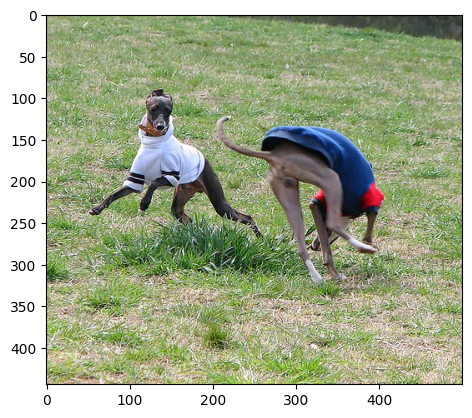

In [29]:
generate_captions(test[40]+'.jpg')

In [30]:
def predict(img_path):
    image_path = img_path
    # load image
    image = load_img(image_path, target_size=(224, 224))
    plt.imshow(image)
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = modelv.predict(image, verbose=0)
    # predict from the trained model
    caption = predict_caption(model, feature, tokenizer,max_length)
    print((f"Caption: {caption[8:-7]}"))

Caption:  the dog is running in the grass


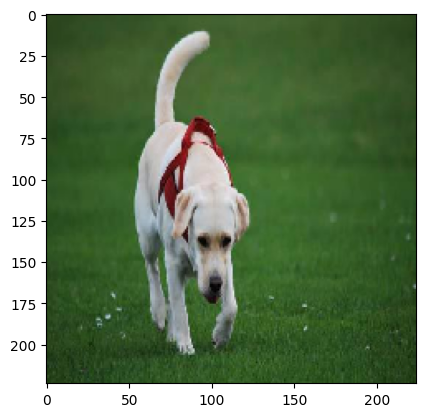

In [31]:
predict('news_dog_run_ideas_wide_and_unrestricted_pet_run.jpg')

In [77]:
import pickle

# Assuming your tokenizer is named `tokenizer`
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [32]:

print(tf.keras.__version__)
print(tf.__version__)

2.10.0
2.10.0
